# Memcached Data Loading

This notebook loads memcached data for subsequent analysis

In [2]:
%matplotlib notebook

In [3]:
import dpkt
import os
import struct
import numpy as np
import pandas as pd
from collections import defaultdict
from pprint import pprint
from collections import namedtuple

Memoizer stores data based on input arguments, making it easier to run repeated analysis.
Check out here with
```
git clone https://github.com/isaac-ped/Memoizer
```

(or don't and the wrapper `@MEMO` will do nothing)

In [4]:
memo = lambda x: x
try:
    from Memoizer import memoize_to_folder
    memo = memoize_to_folder('mcd_memoization')
except Exception as e:
    print("Warning: could not load memoizer")

`ray` helps with task paralellization so loading data from pcaps takes much less time

If `ray` cannot be loaded, `HAS_RAY` is set to `False` and analysis will proceed serially

In [5]:
HAS_RAY=False

In [6]:
try:
    import ray
    ray.shutdown()
    ray.init(num_cpus=12)
    HAS_RAY=True
except Exception as e:
    print("Warning: Could not load ray: %s" % e)

2019-09-13 13:49:42,401	WARNING worker.py:1373 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-09-13 13:49:42,403	INFO node.py:498 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-09-13_13-49-42_403143_959/logs.
2019-09-13 13:49:42,519	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:20159 to respond...
2019-09-13 13:49:42,641	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:39078 to respond...
2019-09-13 13:49:42,647	INFO services.py:809 -- Starting Redis shard with 5.89 GB max memory.
2019-09-13 13:49:42,678	INFO node.py:512 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-09-13_13-49-42_403143_959/logs.
2019-09-13 13:49:42,681	INFO services.py:1475 -- Starting the Plasma object store with 8.84 GB memory using /dev/shm.


### Pcap reading
Read individual pcap files into a dataframe with the packet type and the time at which it went through the tofino

In [7]:
KEYLEN=8

# PktTime defines the columns of the output of read_memcached_pcap
PktTime = namedtuple('pkt_time', ( 'type', 'key', 'time', 'hit'))

@memo
def read_memcached_pcap(out_dir, dst_mac_is_ts = True, compare_counters = True, force_ipv4=True):
    ''' Reads the moongen pcap file in the provided output directory.
    Assumes the pcap file is located in <out_dir>/moongen/moongen.pcap
    Returns dataframe with columns from the named tuple PktTime'''
    if compare_counters:
        count_file = os.path.join(out_dir, 'counters_0.out')
        for line in open(count_file):
            if line.startswith('5/0'):
                n_pkts_str = line.split()[-1]
                n_start_pkts = int(n_pkts_str[:-1])
        count_file = os.path.join(out_dir, 'counters_1.out')
        for line in open(count_file):
            if line.startswith('5/0'):
                n_pkts_str = line.split()[-1]
                n_end_pkts = int(n_pkts_str[:-1])   
        n_expected_pkts = (n_end_pkts - n_start_pkts)
        
        print("Expecting {} packets".format(n_expected_pkts))
                
    pcf = os.path.join(out_dir, 'moongen', 'moongen.pcap')
    
    pkt_times = []

    f = open(pcf, 'rb')
    print("Reading {}".format(pcf))
    pcap=dpkt.pcap.Reader(f)
    total_size = 0
    start_ts = None
    for i, (ts, buf) in enumerate(pcap):
        if i % int(n_expected_pkts / 10) == 0:
            print(i)
        try:
            eth=dpkt.ethernet.Ethernet(buf)

            if dst_mac_is_ts:
                x3, x2, x1 = struct.unpack("!HHH", eth.dst)
                ts = float((x3 << 32) | (x2 << 16) | x1) * 1e-9
                if start_ts is None:
                    start_ts = ts
                ts -= start_ts
            
            if force_ipv4:
                ip = eth.data
                if isinstance(ip, bytes):
                    try:
                        ip = dpkt.ip.IP(eth.data)
                    except (dpkt.UnpackError) as e:
                        print(e)
                        pkt_times.append(PktTime('other (error)', '', ts, -1))
                        continue
                elif not isinstance(ip, dpkt.ip.IP):
                    pkt_times.append(PktTime('other', '', ts, -1))
                    continue
            else:
                ip=eth.data
                if not isinstance(ip, dpkt.ip.IP):
                    pkt_times.append(PktTime('other', '', ts, -1))
                    continue
            udp = ip.data
            spkt = udp.data
            
        except Exception as e:
            print("Exception parsing packet {} : {}".format(buf, e))
            raise

        if type(spkt) == dpkt.icmp.ICMP.Unreach:
            pkt_times.append(PktTime('unreach', '', ts, -1))
            continue

        get_start = spkt.find(b'get ')
        val_start = spkt.find(b'VALUE ')
        hit = -1
        if get_start >= 0:
            key = spkt[:2] + spkt[get_start+4:get_start+4+KEYLEN]
            pkt_type = 'get'
        elif val_start >= 0:
            key = spkt[:2] + spkt[val_start+6:val_start+6+KEYLEN]
            pkt_type = 'value'
            hit = ip.id
        elif b'set ' in spkt:
            key = spkt[:2]
            pkt_type = 'set'
        elif b'STORED' in spkt:
            key = spkt[:2]
            pkt_type = 'stored'
        elif b'END' in spkt:
            key = spkt[:2]
            pkt_type = 'miss'
        else:
            key = ''
            pkt_type = 'other'
            print('Unknown packet load: {}'.format(buf))
        pkt_times.append(PktTime(pkt_type, key, ts, hit))
    
    print("Finished reading pcap: ")
    df = pd.DataFrame(pkt_times)
    print(df.groupby('type').size())
    
    if len(df) < n_expected_pkts - 1:
        print("******************\n"*5 + \
              "GOT {} PKTS, EXPECTED {}\n".format(len(df), n_expected_pkts) +\
              "******************\n"*5
             )        
        
    return df.sort_values('time').reset_index(drop=True)

### Dataframe analysis
Match requests with subsequent responses.

Create two dataframes:
* Latency of all successful requests
* Percentage of requests that were successful over time

The following functions help with matching requests with corresponding responses, made trickier by the fact that keys are repeated over time.

An assumption is made that a request key is not repeated until its response is gathered.
As request keys are a combination of memcached KEY and the 2-byte udp ID field (see memcached documentation for details on udp Id), and UDP IDs are given in order, there is a guarantee that requests will not repeat for 65,536 packets.

At 10Gbps, 65,536 packets are sent every ~$13 ms$

$65536~pkts * (10~Gbps~/~( 8~bits~/~Byte )~/~(256~bytes~/~packet)) = 13.4ms$


In [8]:
65536 / (10e9 / 8 / 256) # packets per second

0.0134217728

Since all latencies are well under 5 ms, this shouldn't be a concern

In [30]:
def repetition_count(keys):
    '''Produces a column with the repetition number of a set of keys.
    (i.e., if keys is [1, 1, 3, 0, 1, 0], will output [0, 1, 0, 0, 2, 1])
    '''
    dup_nums = np.zeros(len(keys), dtype=int)
    keys = keys.astype(object)
    for i in range(1, 100):
        dups = keys.duplicated()
        if dups.any():
            dup_nums[dups] += 1
            keys[dups] = keys[dups] + b'_dup'
        else:
            break
    else:
        print("WARNING: %d duplicates still remain" % (np.count_nonzero(keys.duplicated())))
    return dup_nums

def match_responses(reqs, resps):
    '''Produces a single dataframe with only successful requests and corresponding latencies'''
    reqs = reqs.assign(dup = repetition_count(reqs.key))
    resps = resps.assign(dup = repetition_count(resps.key))
    
    merged = pd.merge(reqs, resps, on='key', how='right', suffixes=('_req', '_resp'))
    merged['latency'] = merged['time_resp'] - merged['time_req']
    
    # Sort by latency, so that in the groupby(), the lowest latency will be first()
    merged = merged[merged['latency'] > 0].sort_values('latency')
    # NB: Assumes that the lowest latency is the correct latency
    merged = merged.groupby(['key', 'dup_resp']).first().reset_index()
    
    merged = merged.sort_values('time_req').reset_index(drop=True)
    merged = merged.rename(columns={'type_req': 'type', 'time_req': 'time', 'hit_resp': 'hit'})
    return merged[['key', 'type', 'time', 'latency', 'hit']]

These functions produce condensed dataframes with latencies or successes over time

In [32]:
# The success dataframe is split into intervals containing this many packets 
# per request-type (set/get) per experiment
PKTS_PER_INTERVAL = 500

def request_success(reqs, resps, matched=None, pkts_per_interval = PKTS_PER_INTERVAL):
    '''Returns a dataframe denoting percentage success over time'''
    reqs = reqs.copy()
    resps = resps.copy()
    
    # Uses match_responses to ensure requests are matched with the correct responses
    if matched is None:
        matched = match_responses(reqs, resps)
    
    interval = (reqs.time.max() - reqs.time.min()) / (len(reqs) / pkts_per_interval)
    matched['interval'] = (matched.time / interval).apply(np.floor)
    reqs['interval'] = (reqs.time / interval).apply(np.floor)
    
    ratio = (matched.groupby('interval').size() / reqs.groupby('interval').size()).rename('success')
    ratio.index *= interval
    ratio.index = ratio.index.rename('time')
    return pd.DataFrame(ratio)
    
def experiment_success(pkts):
    '''For an experiment's packets, returns get/set success over time in a single dataframe'''
    get_success = request_success(pkts[pkts.type == 'get'], pkts[pkts.type == 'value'])
    get_success['type'] = 'get'
    set_success = request_success(pkts[pkts.type == 'set'], pkts[pkts.type == 'stored'])
    set_success['type'] = 'set'
    succ = pd.concat([get_success, set_success], axis=0).reset_index()
    return succ.rename(columns={'success': 'value'})

def experiment_latencies(pkts):
    '''For an experiment's packets, returns get/set latencies per request in a single dataframe'''
    get_lat = match_responses(pkts[pkts.type == 'set'].copy(), pkts[pkts.type == 'stored'].copy())
    set_lat = match_responses(pkts[pkts.type == 'get'].copy(), pkts[pkts.type == 'value'].copy())
    lat = pd.concat([get_lat, set_lat], axis=0).sort_values('time').reset_index(drop=True)
    return lat.rename(columns={'latency': 'value'})

def experiment_stats(pkts):
    '''Returns tuple of dataframes (latency, success) for an experiment'''
    sets = pkts[pkts.type == 'set']
    stored = pkts[pkts.type == 'stored']
    get = pkts[pkts.type == 'get']
    value = pkts[pkts.type == 'value']
    
    set_lat = match_responses(sets, stored)
    get_lat = match_responses(get, value)
    
    print("Got latencies:\n\tSET: %d\n\tGET: %d" % (len(set_lat), len(get_lat)))
    
    lat = pd.concat([get_lat, set_lat], axis=0).sort_values('time').reset_index(drop=True)
    
    get_succ = request_success(get, value, get_lat)
    get_succ['type'] = 'get'
    
    set_succ = request_success(sets, stored, set_lat)
    set_succ['type'] = 'set'
    
    succ = pd.concat([get_succ, set_succ], axis=0).reset_index()
    
    return lat.rename(columns={'latency': 'value'}), succ.rename(columns={'success': 'value'})

### Aggregation
These functions help with aggregation across experiments, and with speeding up loading data

In [33]:
@memo
def load_experiment_stats(base, experiment, label):
    ''' A memoizable function which loads and processes experiment data in a given location'''
    pkts = read_memcached_pcap(os.path.join(base, experiment, '%s_%s' % (experiment, label)))
    return experiment_stats(pkts)

# Can't "ray" a function decorated with `memo` because of **kwargs,
# so we must create a wrapper function
if HAS_RAY:
    @ray.remote
    def load_experiment_stats_parallel(*args):
        return load_experiment_stats(*args)

def aggregate_experiment_stats(base, experiments, labels, parallel = HAS_RAY):
    '''Loads and concatenates all stats for a list of experiments and labels.'''
    all_stats = {}
    for lab in labels:
        for exp in experiments:
            print("Aggregating %s:%s" % (exp, lab))
            if parallel:
                all_stats[(lab, exp)] = load_experiment_stats_parallel.remote(base, exp, lab)
            else:
                all_stats[(lab, exp)] = load_experiment_stats(base, exp, lab)
                
    if parallel:
        for k in all_stats.keys():
            all_stats[k] = ray.get(all_stats[k])
            
    all_latencies = []
    all_successes = []
    for (lab, exp), (lat, suc) in all_stats.items():
        lat = lat.assign(experiment=exp, exp_label=lab)
        suc = suc.assign(experiment=exp, exp_label=lab)
        all_latencies.append(lat)
        all_successes.append(suc)
        
    return (pd.concat(all_latencies, ignore_index=True),
            pd.concat(all_successes, ignore_index=True))

### Default data locations
By default, experiments consist of these sets of data

In [34]:
FPGA_BASE_DIR = '../e2e_output_500k_fpga_hc_14/'
TOFINO_BASE_DIR = '../e2e_output_500k_tofino_hc_14/'
ARISTA_BASE_DIR = '../e2e_output_500k_arista_no_passthrough_2/'
CPU_BASE_DIR = '../e2e_output_500k_cpu_hc_11/'


EXPERIMENTS = ['baseline', 'hc', 'drop', 'fec', 'kv']

DEV_BASE_DIRS = dict(
    fpga = FPGA_BASE_DIR,
    tofino = TOFINO_BASE_DIR,
    arista = ARISTA_BASE_DIR,
    cpu = CPU_BASE_DIR,
)

DEV_EXP_LABELS = dict(
    tofino = range(1, 6),
    fpga = range(1, 6),
    arista = range(1, 6),
    cpu = range(1, 6)
)

## Loading data
Loads all of the data for a given device and saves it in a pickle file easier loading and analysis later

In [35]:
import pickle

def save_device_data(dev, experiments=EXPERIMENTS):
    save_file = '%s_mcd.pickle' % dev
    if os.path.exists(save_file):
        print("Loading from save file %s" % save_file)
        data = pickle.load(open(save_file, 'rb'))
        print("Loaded")
        return data
    data = aggregate_experiment_stats(DEV_BASE_DIRS[dev], experiments, DEV_EXP_LABELS[dev])
    print("Saving to file %s" % save_file)
    pickle.dump(data, open(save_file, 'wb'))
    return data
    

In [15]:
fpga_data = save_device_data('fpga')
tofino_data = save_device_data('tofino')
arista_data = save_device_data('arista')

Aggregating baseline:1
Aggregating hc:1
Aggregating drop:1
Aggregating fec:1
Aggregating kv:1
Aggregating baseline:2
Aggregating hc:2
Aggregating drop:2
Aggregating fec:2
Aggregating kv:2
Aggregating baseline:3
Aggregating hc:3
Aggregating drop:3
Aggregating fec:3
Aggregating kv:3
Aggregating baseline:4
Aggregating hc:4
Aggregating drop:4
Aggregating fec:4
Aggregating kv:4
Aggregating baseline:5
Aggregating hc:5
Aggregating drop:5
Aggregating fec:5
Aggregating kv:5
(pid=1097) Expecting 974998 packets
(pid=1097) Reading ../e2e_output_500k_fpga_hc_14/drop/drop_2/moongen/moongen.pcap
(pid=1097) 0
(pid=1090) Expecting 1000066 packets
(pid=1090) Reading ../e2e_output_500k_fpga_hc_14/hc/hc_3/moongen/moongen.pcap
(pid=1090) 0
(pid=1089) Expecting 975048 packets
(pid=1089) Reading ../e2e_output_500k_fpga_hc_14/fec/fec_2/moongen/moongen.pcap
(pid=1089) 0
(pid=1099) Expecting 1000064 packets
(pid=1099) Reading ../e2e_output_500k_fpga_hc_14/baseline/baseline_2/moongen/moongen.pcap
(pid=1099) 0
(p

(pid=1088) type
(pid=1088) get        450000
(pid=1088) miss            8
(pid=1088) other          10
(pid=1088) set         50000
(pid=1088) stored      47466
(pid=1088) unreach        56
(pid=1088) value      427444
(pid=1088) dtype: int64
(pid=1094) 1000060
(pid=1094) Finished reading pcap: 
(pid=1090) type
(pid=1090) get        450000
(pid=1090) other          10
(pid=1090) set         50000
(pid=1090) stored      50000
(pid=1090) unreach        56
(pid=1090) value      450000
(pid=1090) dtype: int64
(pid=1091) type
(pid=1091) get        450000
(pid=1091) other           9
(pid=1091) set         50000
(pid=1091) stored      47475
(pid=1091) unreach        56
(pid=1091) value      440794
(pid=1091) dtype: int64
(pid=1099) type
(pid=1099) get        450000
(pid=1099) other           8
(pid=1099) set         50000
(pid=1099) stored      50000
(pid=1099) unreach        56
(pid=1099) value      450000
(pid=1099) dtype: int64
(pid=1092) 1000060
(pid=1092) Finished reading pcap: 
(pid=10

(pid=1094) 584874
(pid=1099) 600036
(pid=1092) 593118
(pid=1098) 682612
(pid=1093) 692062
(pid=1089) 682423
(pid=1091) 682661
(pid=1097) 700042
(pid=1096) 682451
(pid=1088) 700042
(pid=1090) 700042
(pid=1095) 692069
(pid=1094) 682353
(pid=1099) 700042
(pid=1092) 691971
(pid=1098) 780128
(pid=1093) 790928
(pid=1089) 779912
(pid=1091) 780184
(pid=1096) 779944
(pid=1097) 800048
(pid=1095) 790936
(pid=1088) 800048
(pid=1090) 800048
(pid=1094) 779832
(pid=1099) 800048
(pid=1092) 790824
(pid=1098) 877644
(pid=1093) 889794
(pid=1089) 877401
(pid=1091) 877707
(pid=1096) 877437
(pid=1097) 900054
(pid=1095) 889803
(pid=1088) 900054
(pid=1090) 900054
(pid=1094) 877311
(pid=1099) 900054
(pid=1092) 889677
(pid=1098) 975160
(pid=1098) Finished reading pcap: 
(pid=1093) 988660
(pid=1093) Finished reading pcap: 
(pid=1089) 974890
(pid=1089) Finished reading pcap: 
(pid=1091) 975230
(pid=1091) Finished reading pcap: 
(pid=1096) 974930
(pid=1096) Finished reading pcap: 
(pid=1098) type
(pid=1098) get   

(pid=1091) 97512
(pid=1089) 100006
(pid=1094) 97497
(pid=1097) 98841
(pid=1090) 100006
(pid=1096) 100006
(pid=1099) 97491
(pid=1095) 97524
(pid=1093) 98860
(pid=1098) 100006
(pid=1092) 100006
(pid=1088) 100006
(pid=1091) 195024
(pid=1089) 200012
(pid=1099) 194982
(pid=1094) 194994
(pid=1095) 195048
(pid=1097) 197682
(pid=1093) 197720
(pid=1096) 200012
(pid=1090) 200012
(pid=1098) 200012
(pid=1092) 200012
(pid=1088) 200012
(pid=1091) 292536
(pid=1089) 300018
(pid=1099) 292473
(pid=1095) 292572
(pid=1097) 296523
(pid=1094) 292491
(pid=1093) 296580
(pid=1096) 300018
(pid=1090) 300018
(pid=1098) 300018
(pid=1092) 300018
(pid=1088) 300018
(pid=1091) 390048
(pid=1097) 395364
(pid=1089) 400024
(pid=1099) 389964
(pid=1095) 390096
(pid=1094) 389988
(pid=1093) 395440
(pid=1096) 400024
(pid=1090) 400024
(pid=1098) 400024
(pid=1092) 400024
(pid=1088) 400024
(pid=1091) 487560
(pid=1099) 487455
(pid=1097) 494205
(pid=1095) 487620
(pid=1089) 500030
(pid=1094) 487485
(pid=1093) 494300
(pid=1096) 50003

(pid=1093) Got latencies:
(pid=1093) 	SET: 47540
(pid=1093) 	GET: 441002
(pid=1099) Got latencies:
(pid=1099) 	SET: 47488
(pid=1099) 	GET: 427369
(pid=1095) Got latencies:
(pid=1095) 	SET: 47427
(pid=1095) 	GET: 427753
(pid=1096) Got latencies:
(pid=1096) 	SET: 50000
(pid=1096) 	GET: 450000
(pid=1090) Got latencies:
(pid=1090) 	SET: 50000
(pid=1090) 	GET: 450000
(pid=1089) Got latencies:
(pid=1089) 	SET: 50000
(pid=1089) 	GET: 450000
(pid=1098) Got latencies:
(pid=1098) 	SET: 50000
(pid=1098) 	GET: 449999
(pid=1091) Expecting 975027 packets
(pid=1091) Reading ../e2e_output_500k_tofino_hc_14/drop/drop_3/moongen/moongen.pcap
(pid=1091) 0
(pid=1097) Expecting 974846 packets
(pid=1097) Reading ../e2e_output_500k_tofino_hc_14/fec/fec_3/moongen/moongen.pcap
(pid=1097) 0
(pid=1094) Expecting 988570 packets
(pid=1094) Reading ../e2e_output_500k_tofino_hc_14/kv/kv_3/moongen/moongen.pcap
(pid=1094) 0
(pid=1099) Expecting 1000064 packets
(pid=1099) Reading ../e2e_output_500k_tofino_hc_14/baseline

(pid=1093) 1000060
(pid=1093) Finished reading pcap: 
(pid=1094) Finished reading pcap: 
(pid=1099) 1000060
(pid=1099) Finished reading pcap: 
(pid=1089) 1000060
(pid=1089) Finished reading pcap: 
(pid=1090) type
(pid=1090) get        450000
(pid=1090) other           8
(pid=1090) set         50000
(pid=1090) stored      47469
(pid=1090) unreach        56
(pid=1090) value      441014
(pid=1090) dtype: int64
(pid=1095) type
(pid=1095) get        450000
(pid=1095) other           6
(pid=1095) set         50000
(pid=1095) stored      47538
(pid=1095) unreach        56
(pid=1095) value      427515
(pid=1095) dtype: int64
(pid=1088) Finished reading pcap: 
(pid=1094) type
(pid=1094) get        450000
(pid=1094) other           8
(pid=1094) set         50000
(pid=1094) stored      47486
(pid=1094) unreach        56
(pid=1094) value      441020
(pid=1094) dtype: int64
(pid=1098) 1000060
(pid=1098) Finished reading pcap: 
(pid=1089) type
(pid=1089) get        450000
(pid=1089) other           

In [29]:
cpu_data = save_device_data('cpu', ['baseline', 'hc'])

Aggregating baseline:1
Aggregating hc:1
Aggregating baseline:2
Aggregating hc:2
Aggregating baseline:3
Aggregating hc:3
Aggregating baseline:4
Aggregating hc:4
Aggregating baseline:5
Aggregating hc:5
(pid=1088) Loading from mcd_memoization/load_experiment_stats__base-e2e_output_500k_cpu_hc_11__experiment-baseline__label-2.pickle
(pid=1091) Loading from mcd_memoization/load_experiment_stats__base-e2e_output_500k_cpu_hc_11__experiment-hc__label-5.pickle
(pid=1096) Loading from mcd_memoization/load_experiment_stats__base-e2e_output_500k_cpu_hc_11__experiment-baseline__label-5.pickle
(pid=1089) Loading from mcd_memoization/load_experiment_stats__base-e2e_output_500k_cpu_hc_11__experiment-baseline__label-4.pickle
(pid=1092) Loading from mcd_memoization/load_experiment_stats__base-e2e_output_500k_cpu_hc_11__experiment-hc__label-1.pickle
(pid=1099) Loading from mcd_memoization/load_experiment_stats__base-e2e_output_500k_cpu_hc_11__experiment-hc__label-2.pickle
(pid=1098) Loading from mcd_memo

Saving to file cpu_mcd.pickle


# Sample data plotting
The following cells contain sample plots of data to verify that experiments ran correctly

In [19]:
# plot some sample stats
import matplotlib.pyplot as plt

def plot_sample_stat(df, axs, column='value', exp_label=None, experiments=EXPERIMENTS, sample_size=None, roll_fn=None, color=None):
    if exp_label is None:
        exp_label = df.iloc[0].exp_label
    df_label = df[df.exp_label == exp_label]
    for ax, experiment in zip(axs, experiments):
        plt.sca(ax)
        df_exp = df_label[df_label.experiment == experiment]
        for pkt_type in ('get', 'set',):
            df_sample = df_exp[df_exp.type == pkt_type]

            if sample_size is not None:
                df_sample = df_sample.sample(sample_size)
  
            if roll_fn is None:
                handle = plt.plot(df_sample.time, df_sample[column], '.',  color=color, markersize=1, label=pkt_type)
            else:
                df_sample = df_sample.sort_values('time')
                df_sample['tdelta'] = pd.to_datetime(df_sample.time * 1e9)
                if roll_fn == 'median':
                    df_roll = df_sample.rolling(pd.Timedelta(1, 's'), on='tdelta')[['time', column]].median()
                elif roll_fn == 'mean':
                    df_roll = df_sample.rolling(pd.Timedelta(1, 's'), on='tdelta')[['time', column]].mean()
                handle = plt.plot(df_roll.time, df_roll[column], '-', color=color, label=pkt_type)
                
    return handle
         
def plot_group_stat(df, axs, column='value', start_time = 0, stop_time = 100, experiments=EXPERIMENTS):
    df = df[(df.time > start_time) & (df.time < stop_time)]
    for ax, experiment in zip(axs, experiments):
        plt.sca(ax)
        df_exp = df[df.experiment == experiment]
        for i, pkt_type in enumerate(['get', 'set']):
            df_type = df_exp[df_exp.type == pkt_type]
            grouped = df_type.groupby('exp_label')[column]
            latencies = grouped.median()
            lows, highs = grouped.quantile(.01), grouped.quantile(.99)
            plt.errorbar(latencies.index + i/3, latencies, yerr=[latencies-lows, highs-latencies], 
                         fmt='o', label=pkt_type, fillstyle='none')
        plt.title(experiment)

<IPython.core.display.Javascript object>


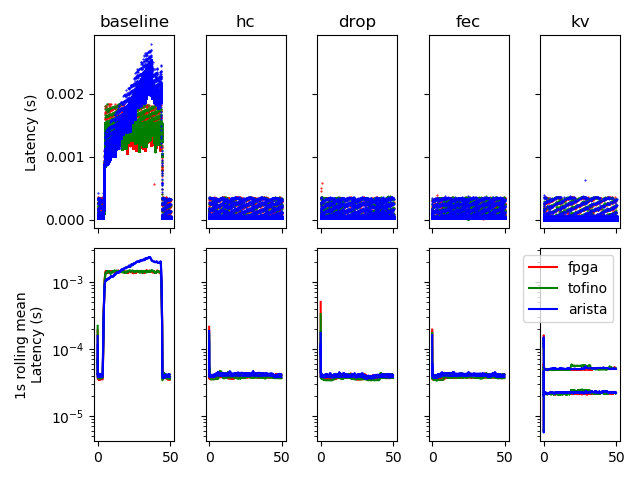

In [20]:
experiments = ['baseline', 'hc']
fig, axs = plt.subplots(2, 5, squeeze=False, sharey='row', sharex=True)
f = plot_sample_stat(fpga_data[0], axs[0,:], color='r')
t = plot_sample_stat(tofino_data[0], axs[0,:], color='g')
a = plot_sample_stat(arista_data[0], axs[0,:], color='b')

f = plot_sample_stat(fpga_data[0], axs[1,:], color='r', roll_fn='mean')
t = plot_sample_stat(tofino_data[0], axs[1,:], color='g', roll_fn='mean')
a = plot_sample_stat(arista_data[0], axs[1,:], color='b', roll_fn='mean')

# plt.legend(f+t+a, ['fpga', 'tofino', 'arista'], loc='upper right')
plt.legend(f+t+a, ['fpga', 'tofino', 'arista'], loc='upper right')

for exp, ax in zip(EXPERIMENTS, axs[0,:]):
    ax.set_title(exp)

axs[0][0].set_ylabel("Latency (s)")
axs[1][0].set_ylabel("1s rolling mean\nLatency (s)")
axs[1][0].set_yscale('log')
plt.tight_layout()

In [ ]:
col = 'latency'
fig, axs = plt.subplots(2, len(EXPERIMENTS), squeeze=False, sharey='row', sharex=True)

f = plot_sample_stat(fpga_data[0], axs[1,:], col, color='r', sample_size=1000)
a = plot_sample_stat(arista_data[0], axs[1,:], col,  color='b', sample_size=1000)

f = plot_sample_stat(fpga_data[0], axs[0,:], col, color='r', sample_size=None)
a = plot_sample_stat(arista_data[0], axs[0,:], col, color='b', sample_size=None)

axs[0][0].set_yscale('log')
axs[1][0].set_yscale('log')
plt.legend(f+a, ['fpga', 'arista'], loc='upper right')

for exp, ax in zip(EXPERIMENTS, axs[0,:]):
    ax.set_title(exp)

axs[0][0].set_ylabel("\nLatency (s)")
axs[1][0].set_ylabel("1000 Samples\nLatency (s)")

plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(3, len(EXPERIMENTS), sharey=True, figsize=(7,5))
column = 'latency'
plot_group_stat(tofino_data[0], axs[0,:], column, start_time=10, stop_time=40)
plot_group_stat(fpga_data[0], axs[1,:], column, start_time=10, stop_time=40)
plot_group_stat(arista_data[0], axs[2,:], column, start_time=10, stop_time=40)
plt.yscale("log")

<IPython.core.display.Javascript object>


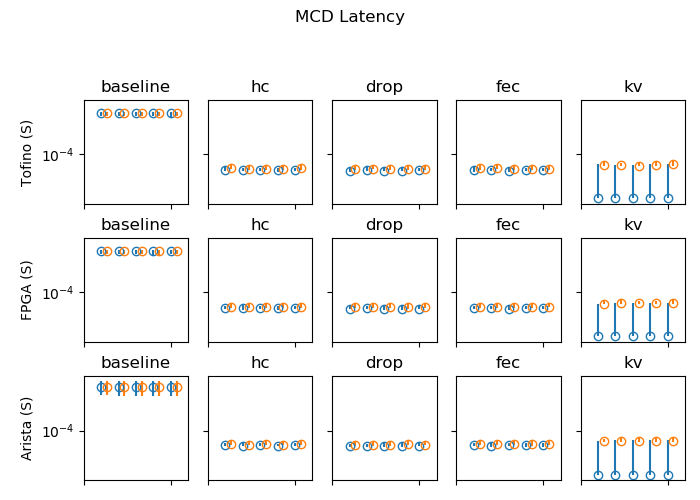

In [24]:
%matplotlib notebook
fig, axs = plt.subplots(3, len(EXPERIMENTS), squeeze=False, sharey=True, sharex=True, figsize=(7,5))

plot_group_stat(tofino_data[0], axs[0,:], start_time=5, stop_time=35)
axs[0][0].set_ylabel("Tofino (S)")

plot_group_stat(fpga_data[0], axs[1,:], start_time=5, stop_time=35)
axs[1][0].set_ylabel("FPGA (S)")

plot_group_stat(arista_data[0], axs[2,:], start_time=5, stop_time=35)
axs[2][0].set_ylabel("Arista (S)")


plt.suptitle("MCD Latency")
plt.xlim([0, 6])
axs[0][0].set_xticklabels([])
plt.tight_layout()
plt.subplots_adjust(top=.8)
plt.yscale('log')


<IPython.core.display.Javascript object>


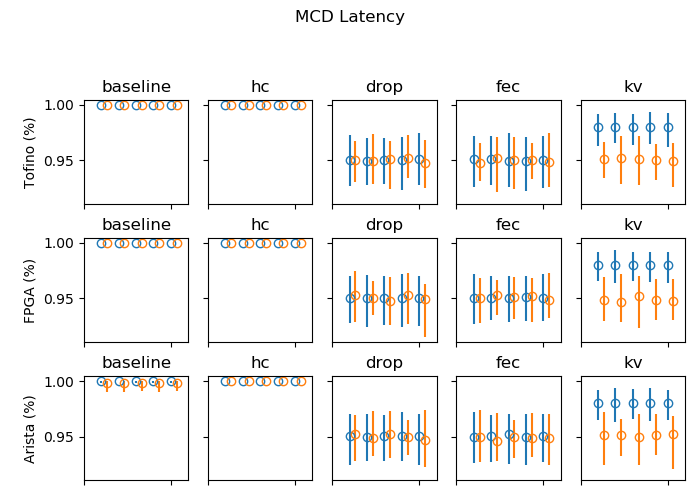

In [23]:
%matplotlib notebook
fig, axs = plt.subplots(3, len(EXPERIMENTS), squeeze=False, sharey=True, sharex=True, figsize=(7,5))

plot_group_stat(tofino_data[1], axs[0,:], start_time=5, stop_time=35)
axs[0][0].set_ylabel("Tofino (%)")

plot_group_stat(fpga_data[1], axs[1,:], start_time=5, stop_time=35)
axs[1][0].set_ylabel("FPGA (%)")

plot_group_stat(arista_data[1], axs[2,:], start_time=5, stop_time=35)
axs[2][0].set_ylabel("Arista (%)")


plt.suptitle("MCD Latency")
plt.xlim([0, 6])
axs[0][0].set_xticklabels([])
plt.tight_layout()
plt.subplots_adjust(top=.8)
